In [16]:
%load_ext autoreload
%autoreload 2
%matplotlib widget
import os, sys, getpass
user = getpass.getuser()
sys.path.append(f'/home/{user}/codes/hpe_library/')
from lib_import import *
from my_utils import *
os.chdir(f'/home/{user}/codes/MotionBERT')
import scipy.io

root_3dhp = f'/home/{user}/Datasets/HAAI/3DHP'
source = 'original' # s
root_original = os.path.join(root_3dhp, source)
train_folder = os.path.join(root_original, 'train')
test_folder = os.path.join(root_original, 'test')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [17]:
# get test data
data_dict, cam_params = load_3dhp_original('test')

TS1 (6151, 17, 2) (6151, 17, 3) (6151,)
TS2 (6080, 17, 2) (6080, 17, 3) (6080,)
TS3 (5838, 17, 2) (5838, 17, 3) (5838,)
TS4 (6007, 17, 2) (6007, 17, 3) (6007,)
TS5 (320, 17, 2) (320, 17, 3) (320,)
TS6 (492, 17, 2) (492, 17, 3) (492,)


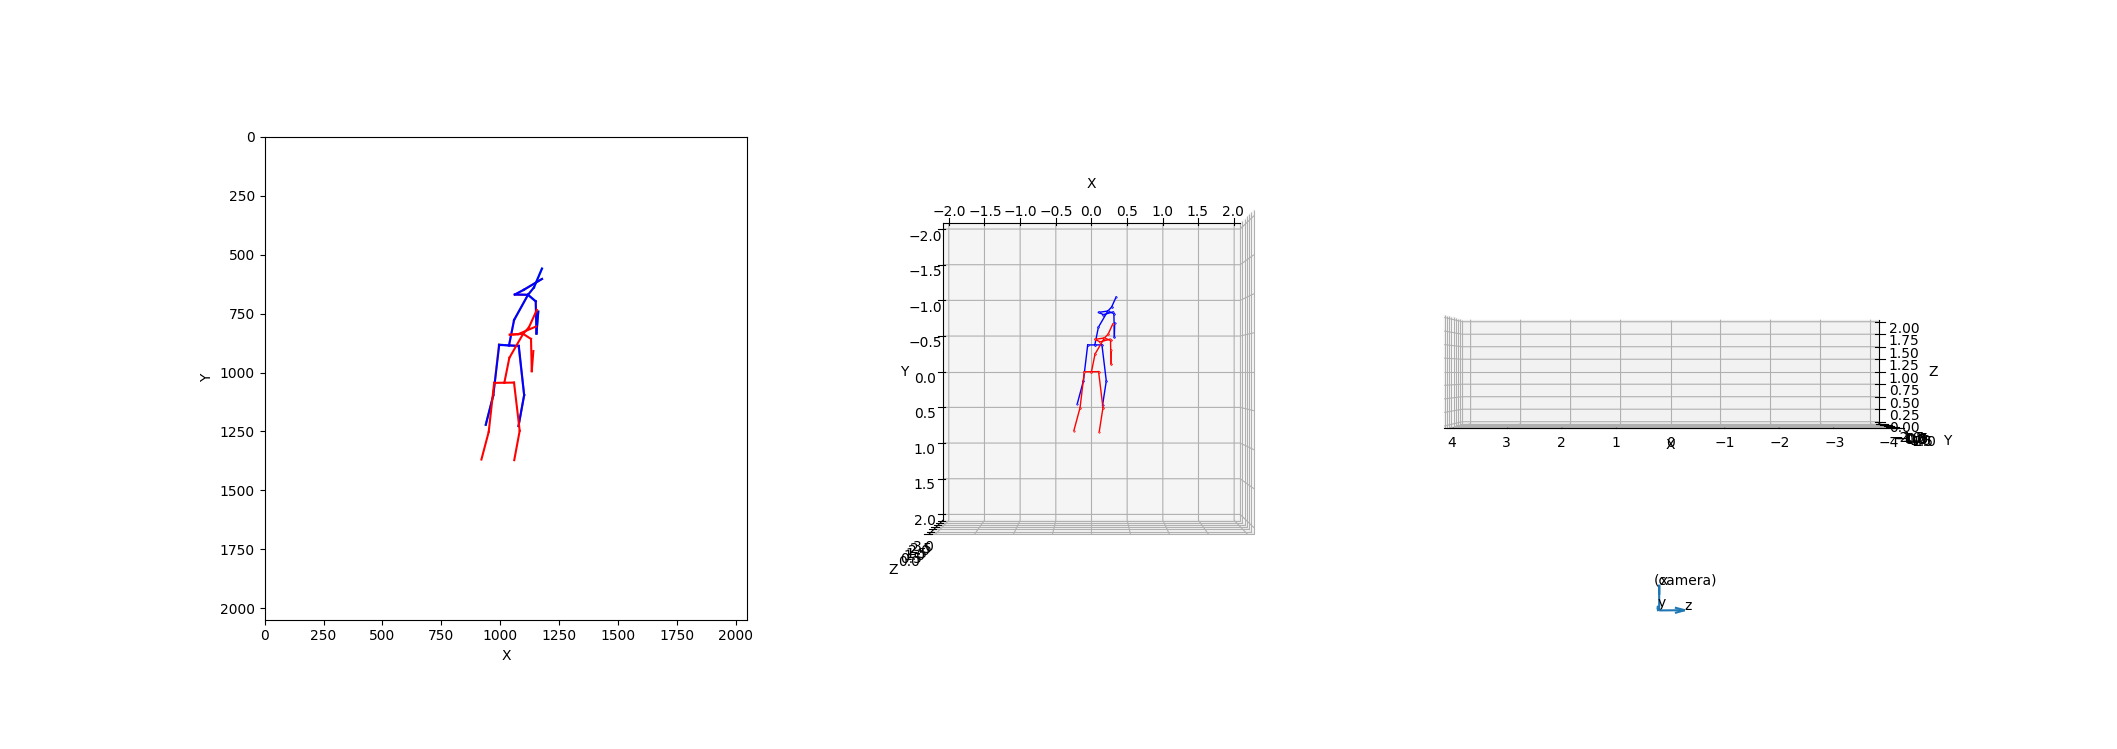

In [109]:
subject = 'TS4'
C = cam_params[subject]['C']
R = cam_params[subject]['R']
t = cam_params[subject]['t']
intrinsic = cam_params[subject]['intrinsic']
extrinsic = cam_params[subject]['extrinsic']
H, W = cam_params[subject]['H'], cam_params[subject]['W']
fx, fy, cx, cy = intrinsic[0, 0], intrinsic[1, 1], intrinsic[0, 2], intrinsic[1, 2]

camera = Camera(origin=C, 
                calib_mat=intrinsic, 
                cam_default_R=R, 
                IMAGE_HEIGHT=H, 
                IMAGE_WIDTH=W,
                cam_name='camera')

frame_num = 1600
img_2d_gt = data_dict[subject]['annot2'][frame_num]
cam_3d = data_dict[subject]['annot3']
pelvis = cam_3d[frame_num, 0]
cam_3d_hat = get_rootrel_pose(cam_3d)
cam_3d_from_canonical_3d = cam_3d.copy()
cam_3d_from_canonical_3d[...,:2] -= cam_3d[:, 0:1, :2]
img_2d_from_canonical_3d = np.einsum('ij,jkl->ikl', intrinsic, cam_3d_from_canonical_3d.T).T
img_2d_from_canonical_3d = img_2d_from_canonical_3d / img_2d_from_canonical_3d[..., 2:3]

box = infer_box(cam_3d[frame_num], {'fx': fx, 'fy': fy, 'cx': cx, 'cy': cy}, 0)
img_2d, img_3d = camera_to_image_frame(cam_3d[frame_num], box, {'fx': fx, 'fy': fy, 'cx': cx, 'cy': cy}, 0) 
img_3d_hat = get_rootrel_pose(img_3d) # (17, 3) # root-relative pose 

box = infer_box(cam_3d_from_canonical_3d[frame_num], {'fx': fx, 'fy': fy, 'cx': cx, 'cy': cy}, 0)
img_2d_from_canonical_3d, _ = camera_to_image_frame(cam_3d_from_canonical_3d[frame_num], box, {'fx': fx, 'fy': fy, 'cx': cx, 'cy': cy}, 0)

# 2.5d factor
pred_lambda, losses = optimize_scaling_factor(img_3d_hat, cam_3d_hat[frame_num], stop_tolerance=0.0001) # x,y,z 사용

fig = plt.figure(1)
fig.clear()
ax = axes_2d(fig, loc=131, H=H, W=W)
ax_cam = axes_3d(fig, loc=132, view=(-90,-90), xlim=(-2, 2), ylim=(-2, 2), zlim=(0, 3))
ax_world = axes_3d(fig, loc=133, view=(0, 90), xlim=(-4, 4), zlim=(0, 2))
draw_2d_pose(ax, img_2d, H=H, W=W)
draw_2d_pose(ax, img_2d_gt, H=H, W=W, color='b')  
draw_2d_pose(ax, img_2d_from_canonical_3d, H=H, W=W, color='r', label='canonical from same z')

#draw_3d_pose(ax_cam, cam_3d)
#draw_3d_pose(ax_cam, cam_3d_hat[frame_num]/1000)
#draw_3d_pose(ax_cam, img_3d_hat*pred_lambda/1000, color='r')
draw_3d_pose(ax_cam, cam_3d[frame_num]/1000, color='b')
draw_3d_pose(ax_cam, cam_3d_from_canonical_3d[frame_num]/1000, color='r')

plt.sca(ax_world)
camera.cam_frame.draw3d()
plt.show()

In [16]:
pelvis

array([ 615.334,  -55.454, 2441.88 ])

### Generate test pkl

In [52]:
save_folder = '/home/hrai/codes/MotionBERT/data/motion3d/3dhp_gt_test_canonical_3d_with_same_z_pkl'
if not os.path.exists(save_folder):
    os.makedirs(save_folder)

cam_params = readpkl(f'/home/{user}/codes/MotionBERT/custom_codes/Dataset_generation/3dhp/3dhp_test_cam_params.pkl')

for subject in os.listdir(test_folder):
    if 'TS' not in subject:
        continue
    file_name = subject + '.pkl'
    save_path = os.path.join(save_folder, file_name)
    # if os.path.exists(save_path):
    #     print(f'{file_name} already exists')
    #     continue

    data = {}
    for key in ['joint_2d', 'joint_2d_from_canonical_3d', 'confidence', 'joint3d_image', 'camera_name', 'action', 'source', 'frame', 'cam_3d', 'cam_3d_from_canonical_3d', 'cam_param']:
        data[key] = []
        
    cam_param = cam_params[subject]
    C = cam_params[subject]['C']
    R = cam_params[subject]['R']
    t = cam_params[subject]['t']
    intrinsic = cam_params[subject]['intrinsic']
    extrinsic = cam_params[subject]['extrinsic']
    H, W = cam_params[subject]['H'], cam_params[subject]['W']
    fx, fy, cx, cy = intrinsic[0, 0], intrinsic[1, 1], intrinsic[0, 2], intrinsic[1, 2]

    source = subject
    action = subject
    camera_id = subject
    
    cam_3d = data_dict[subject]['annot3']
    #world_3d = (R.T @ (cam_3d - t).T).T/1000
    cam_3d_from_canonical_3d = cam_3d.copy()
    cam_3d_from_canonical_3d[...,:2] -= cam_3d[:, 0:1, :2]
    img_2d_from_canonical_3d = np.einsum('ij,jkl->ikl', intrinsic, cam_3d_from_canonical_3d.T).T
    img_2d_from_canonical_3d = img_2d_from_canonical_3d / img_2d_from_canonical_3d[..., 2:3]

    for frame_num in tqdm(range(len(data_dict[subject]['annot2']))):
        #cam_3d_hat = get_rootrel_pose(cam_3d)
        box = infer_box(cam_3d[frame_num], {'fx': fx, 'fy': fy, 'cx': cx, 'cy': cy}, 0)
        img_2d, img_3d = camera_to_image_frame(cam_3d[frame_num], box, {'fx': fx, 'fy': fy, 'cx': cx, 'cy': cy}, 0) 
        img_3d_hat = get_rootrel_pose(img_3d) # (17, 3) # root-relative pose 

        # 2.5d factor
        #pred_lambda, losses = optimize_scaling_factor(img_3d_hat, cam_3d_hat, stop_tolerance=0.0001) # x,y,z 사용
        
        # joint 2.5d image
        #img_25d = img_3d * pred_lambda

        # store
        data['joint_2d'].append(np.array(img_2d).copy()) 
        data['joint_2d_from_canonical_3d'].append(np.array(img_2d_from_canonical_3d[frame_num]).copy())
        data['confidence'].append(np.ones(17)) 
        data['joint3d_image'].append(np.array(img_3d).copy()) 
        #data['joints_2.5d_image'].append(np.array(img_25d).copy()) 
        #data['2.5d_factor'].append(np.array(pred_lambda).copy()) 
        data['camera_name'].append(np.array(camera_id).copy()) 
        data['action'].append(np.array(action).copy()) 
        data['source'].append(np.array(source).copy()) 
        data['frame'].append(np.array(frame_num).copy()) 
        data['cam_3d'].append(np.array(cam_3d[frame_num]).copy()) 
        data['cam_3d_from_canonical_3d'].append(np.array(cam_3d_from_canonical_3d[frame_num]).copy())
        data['cam_param'].append(np.array(cam_param).copy())

    
    savepkl(data, save_path)
    #break

100%|██████████| 492/492 [00:00<00:00, 23481.19it/s]
